# Understanding MLPs and Activation Functions (Peanut vs Donut)

This notebook:
- Generates a custom **Peanut vs Donut** dataset
- **Class 0 ("peanut")**: a two-lobed, peanut-shaped inner region
- **Class 1 ("donut")**: an outer ring surrounding the peanut
- Defines and compares four activation functions: Sigmoid, Tanh, ReLU, Leaky ReLU
- Trains identical MLPs with different activations
`


In [81]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = True

# Create figures directory
os.makedirs("figures", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 1. Generate Peanut vs Donut dataset

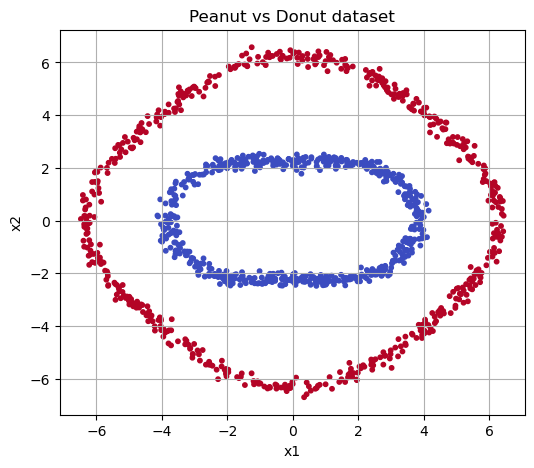

In [84]:
def generate_peanut_vs_donut(n_points_per_class=600, noise=0.15, random_state=42):
    """Generate a 2D dataset with:
    - Class 0: peanut-shaped inner region
    - Class 1: donut-shaped outer ring
    """
    rng = np.random.RandomState(random_state)

    theta0 = rng.uniform(0, 2 * np.pi, size=n_points_per_class)
    theta1 = rng.uniform(0, 2 * np.pi, size=n_points_per_class)

    # Peanut-shaped inner class (class 0)
    r0 = 3.0 + 0.8 * np.cos(2 * theta0)  # two lobes
    r0_noisy = r0 + rng.randn(n_points_per_class) * noise
    x0 = r0_noisy * np.cos(theta0)
    y0 = r0_noisy * np.sin(theta0)

    # Donut-shaped outer class (class 1)
    r1 = 6.0 + 0.3 * np.cos(4 * theta1)  # slightly wavy ring
    r1_noisy = r1 + rng.randn(n_points_per_class) * noise
    x1 = r1_noisy * np.cos(theta1)
    y1 = r1_noisy * np.sin(theta1)

    X = np.vstack([
        np.stack([x0, y0], axis=1),
        np.stack([x1, y1], axis=1)
    ])
    y = np.hstack([
        np.zeros(n_points_per_class, dtype=int),
        np.ones(n_points_per_class, dtype=int)
    ])

    return X, y

X, y = generate_peanut_vs_donut()

plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap='coolwarm',)
plt.title("Peanut vs Donut dataset")
plt.xlabel("x1")
plt.ylabel("x2")

# Save dataset figure
plt.savefig("figures/fig_dataset.png", dpi=150, bbox_inches="tight")
plt.show()

In [86]:
# Save Peanut vs Donut dataset as CSV
import pandas as pd

# Create DataFrame
df = pd.DataFrame({
    "x1": X[:, 0],
    "x2": X[:, 1],
    "label": y
})

# Save to CSV
df.to_csv("peanut_donut_dataset.csv", index=False)

print("Dataset saved as peanut_donut_dataset.csv")


Dataset saved as peanut_donut_dataset.csv


In [88]:
from IPython.display import HTML

HTML('<a href="peanut_donut_dataset.csv" download="peanut_donut_dataset.csv">Download CSV file</a>')


## 2. Train/test split and scaling

In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

X_train_t.shape, y_train_t.shape

(torch.Size([840, 2]), torch.Size([840]))

## 3. Activation functions and comparison plot

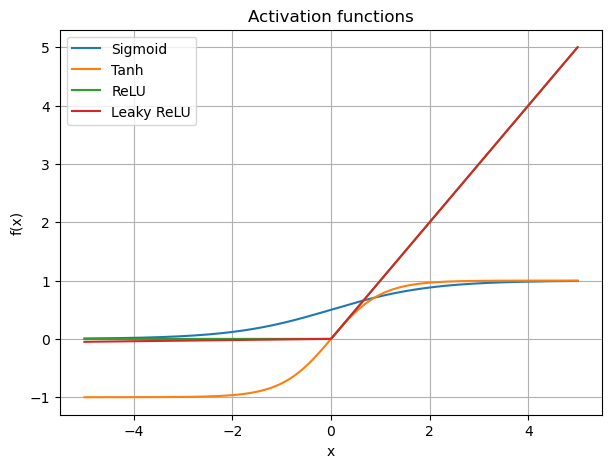

In [94]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def tanh(x):
    return torch.tanh(x)

def relu(x):
    return torch.clamp(x, min=0.0)

def leaky_relu(x, negative_slope=0.01):
    return torch.where(x > 0, x, negative_slope * x)

activations_for_plot = {
    "Sigmoid": sigmoid,
    "Tanh": tanh,
    "ReLU": relu,
    "Leaky ReLU": leaky_relu,
}

x = torch.linspace(-5, 5, 400)

plt.figure(figsize=(7, 5))
for name, f in activations_for_plot.items():
    y_act = f(x).detach().numpy()
    plt.plot(x.numpy(), y_act, label=name)

plt.title("Activation functions")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)

# Save activation comparison figure
plt.savefig("figures/fig_activations.png", dpi=150, bbox_inches="tight")
plt.show()

## 4. Define MLP model with configurable activation

In [97]:
class MLP(nn.Module):
    def __init__(self, activation_fn):
        super().__init__()
        self.activation = activation_fn
        self.layer1 = nn.Linear(2, 64)
        self.layer2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, 2)

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        return self.out(x)

## 5. Training loop

In [100]:
def train_model(name, activation_fn, epochs=80, lr=1e-3):
    print(f"Training model with {name} activation...")
    model = MLP(activation_fn).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_losses": [],
        "test_accuracies": []
    }

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        loss.backward()
        optimizer.step()

        history["train_losses"].append(loss.item())

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            preds_test = model(X_test_t).argmax(dim=1)
            acc_test = (preds_test == y_test_t).float().mean().item()
            history["test_accuracies"].append(acc_test)

    print(f"{name}: final test accuracy = {history['test_accuracies'][-1]:.3f}")
    return model, history

## 6. Train models for each activation

In [103]:
activation_functions = {
    "Sigmoid": sigmoid,
    "Tanh": tanh,
    "ReLU": relu,
    "Leaky ReLU": leaky_relu,
}

results = {}

for name, act in activation_functions.items():
    model, history = train_model(name, act)
    results[name] = {"model": model, "history": history}

Training model with Sigmoid activation...
Sigmoid: final test accuracy = 0.847
Training model with Tanh activation...
Tanh: final test accuracy = 1.000
Training model with ReLU activation...
ReLU: final test accuracy = 1.000
Training model with Leaky ReLU activation...
Leaky ReLU: final test accuracy = 1.000


## 7. Training loss comparison (saved as figure)

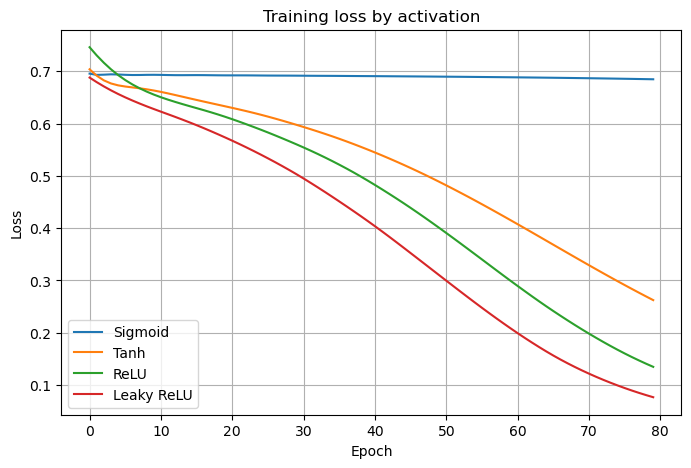

In [106]:
plt.figure(figsize=(8, 5))
for name, info in results.items():
    plt.plot(info["history"]["train_losses"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss by activation")
plt.legend()
plt.grid(True)

# Save training loss figure
plt.savefig("figures/fig_training_loss.png", dpi=150, bbox_inches="tight")
plt.show()

## 8. Combined decision boundary plot (saved as figure)

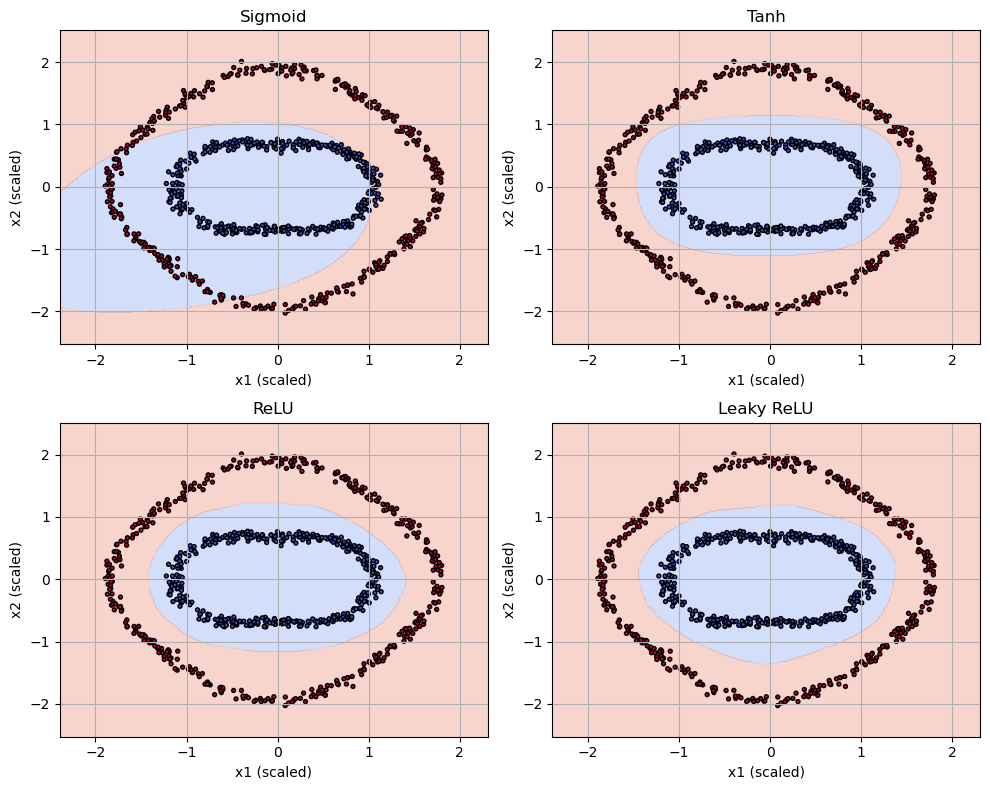

In [109]:
def plot_all_decision_boundaries(results, X, y, scaler=None):
    # Prepare scaled version for visualization
    if scaler is not None:
        X_vis = scaler.transform(X)
    else:
        X_vis = X

    x_min, x_max = X_vis[:, 0].min() - 0.5, X_vis[:, 0].max() + 0.5
    y_min, y_max = X_vis[:, 1].min() - 0.5, X_vis[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_t = torch.tensor(grid, dtype=torch.float32).to(device)

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()

    for ax, (name, info) in zip(axes, results.items()):
        model = info["model"]
        model.eval()
        with torch.no_grad():
            preds = model(grid_t).argmax(dim=1).cpu().numpy()
        Z = preds.reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.3, levels=2, cmap="coolwarm")
        ax.scatter(X_vis[:, 0], X_vis[:, 1], c=y, s=8, cmap="coolwarm",edgecolor='k')
        ax.set_title(name)
        ax.set_xlabel("x1 (scaled)")
        ax.set_ylabel("x2 (scaled)")

    plt.tight_layout()
    plt.savefig("figures/fig_decision_boundaries.png", dpi=150, bbox_inches="tight")
    plt.show()

plot_all_decision_boundaries(results, X_train, y_train, scaler=scaler)

## 9. GIT Repository

https://github.com/Ram-sai7/MLP_Activation_Functions/commits?author=Ram-sai7